## Genetic compression search on LeNet-5 

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.train import *
from utils.weight_sharing import *
from utils.genetic import GeneticController
from utils.plot import *

Setting some global parameters (for the genetic search settings look in `utils.genetic_config.py`)

In [2]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = None
EPOCHS = 100

NET_PATH = './models/lenet/saves/lenet.save'

ACC_MULTIPLIER = 4
CR_MULTIPLIER = 1

NUM_GENERATIONS = 2
NUM_PULATION = 6

SAVE_EVOL_FILE = './results/test_GA_save.csv'
SAVE_EVERY = 1

Geting somewhat trained LeNet-5

In [3]:
dataset = MnistDataset(BATCH_SIZE, './data', val_split=0.5)
model = LeNet5(N_CLASSES)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

Setting weight share controller

In [4]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [5]:
share_order = [0, 1, 2, 3, 4]
retrain_amount = [0, 0, 0, 0, 0]

def fitness_fc(individual):
    # reset the net
    get_trained(model, NET_PATH, train_settings)
    for layer in ws_controller.model_layers:
        layer.weight.requires_grad = True
    
    # share weigts by chromosome
    individual.data = ws_controller.share(individual.chromosome, share_order, retrain_amount)

    if individual.data['accuracy'] <= 0.95:
        return ACC_MULTIPLIER * individual.data['accuracy']

    return ACC_MULTIPLIER * individual.data['accuracy'] + CR_MULTIPLIER * math.log(individual.data['compression'])
    
lam_fit = lambda indiv : fitness_fc(indiv) 


Defining logging function and elit dealing function

In [6]:
data = {
    'generation': [],
    'fitness': [],
    'chromosome': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'generation' : 'uint8',
    'fitness': 'float32',
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

evol_data = pd.read_csv(SAVE_EVOL_FILE).astype(data_types) if os.path.exists(SAVE_EVOL_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(gen_cont:GeneticController):
    global evol_data

    new_data = copy.deepcopy(data)

    for indiv in gen_cont.population:

        new_data['generation'].append(gen_cont.generation)
        new_data['fitness'].append(indiv.fitness)
        new_data['chromosome'].append(indiv.chromosome)
        new_data['accuracy'].append(indiv.data['accuracy'])
        new_data['accuracy_loss'].append(before_loss - indiv.data['accuracy'])
        new_data['compression'].append(indiv.data['compression'])
        new_data['share_t'].append(indiv.data['times']['share'])
        new_data['train_t'].append(indiv.data['times']['train'])
        new_data['acc_t'].append(indiv.data['times']['test'])

    # saving progress
    evol_data = evol_data.append(pd.DataFrame(new_data).astype(data_types))
    if gen_cont.generation % SAVE_EVERY == SAVE_EVERY - 1:
        evol_data.reset_index(drop=True, inplace=True)
        evol_data.to_csv(SAVE_EVOL_FILE, index=False)
    
def deal_elit(population):
    for individual in population:
        if individual.data is not None:
            individual.data['times'] = {
                'share': 0,
                'train': 0,
                'test': 0
            }


Run evolution

In [7]:
chromosome_ranges = [range(1, 21), range(1, 21), range(1, 21), range(1, 21), range(1, 21)]

genetic = GeneticController(chromosome_ranges, NUM_PULATION, lam_fit)

if evol_data.size != 0:
    genetic.load_from_pd(evol_data)

genetic.run_evolution(NUM_GENERATIONS, logger_fc, deal_elit, True)

Generation 0/2 (64) evaluated, best fitness 6.600321292877197
Generation 1/2 (65) evaluated, best fitness 6.600321353003574
Generation 2/2 (66) evaluated, best fitness 6.600321353003574


See output

In [8]:
evol_data

,generation,fitness,chromosome,accuracy,accuracy_loss,compression,share_t,train_t,acc_t
0,0,6.235783,"[2, 10, 14, 14, 8]",0.9576,0.0270,11.082671,0.681597,0.0,3.751433
1,0,5.925244,"[7, 18, 12, 17, 8]",0.9818,0.0028,7.374621,0.909940,0.0,3.934837
2,0,5.900707,"[17, 20, 3, 19, 15]",0.9636,0.0210,7.739265,0.462463,0.0,3.640773
3,0,5.894269,"[20, 13, 16, 5, 11]",0.9760,0.0086,7.317504,0.842196,0.0,3.561660
4,0,0.400800,"[19, 16, 12, 9, 1]",0.1002,0.8844,11.511865,0.657771,0.0,3.930791
...,...,...,...,...,...,...,...,...,...
391,65,6.487636,"[18, 7, 2, 6, 4]",0.9584,0.0262,14.211281,0.288771,0.0,3.636315
392,65,6.440321,"[2, 7, 18, 3, 4]",0.9516,0.0330,13.928275,0.695228,0.0,3.597517
393,65,6.398782,"[2, 19, 14, 3, 4]",0.9510,0.0336,13.393662,0.620090,0.0,3.313689
394,65,6.312014,"[17, 4, 4, 17, 4]",0.9734,0.0112,11.228036,0.440509,0.0,3.543583


Plotting data

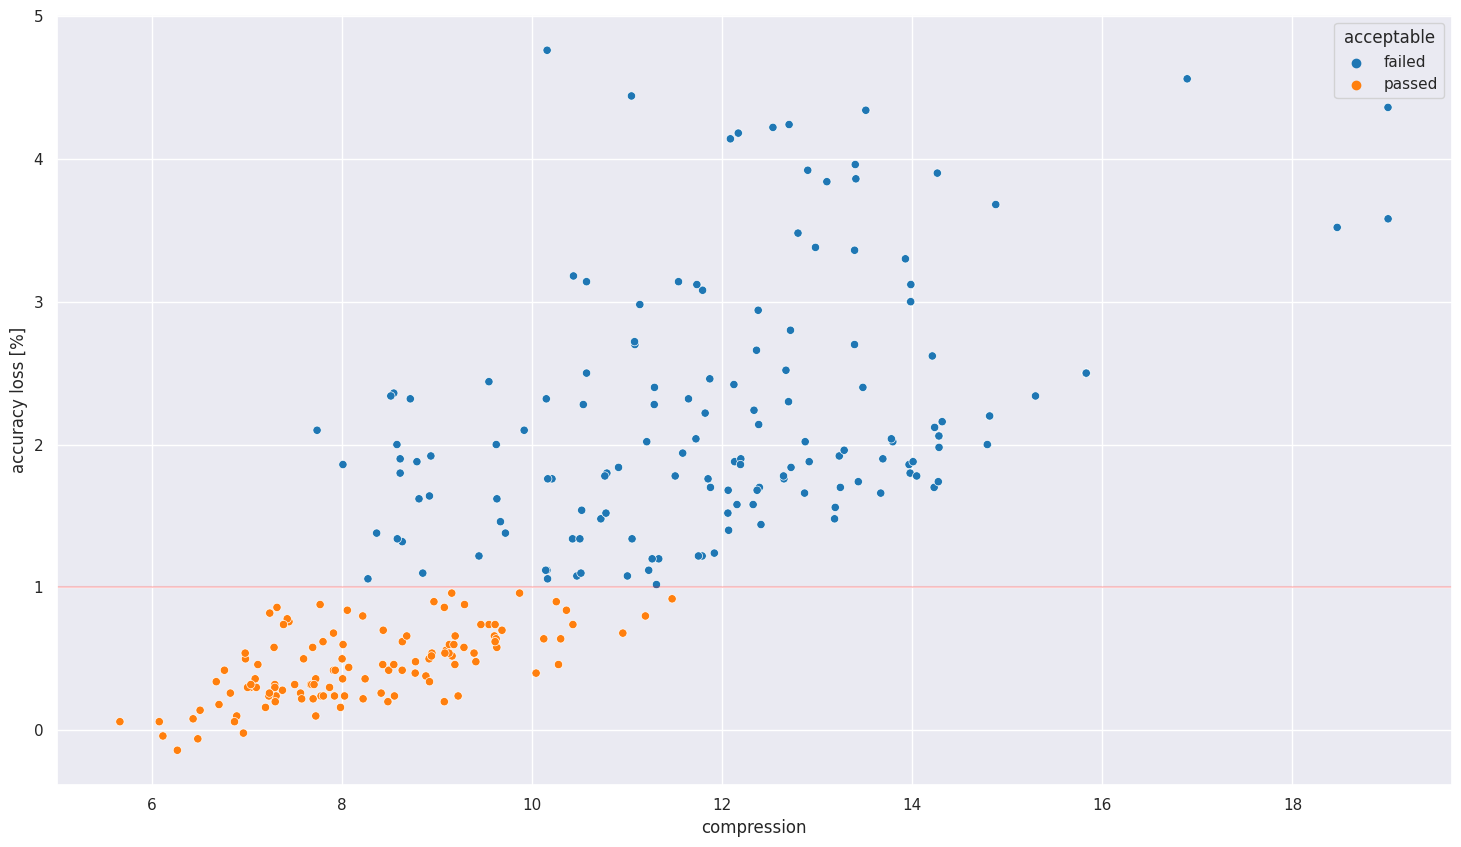

In [9]:
plot_alcr(evol_data)